In [2]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

### High-Dimensional Linear Regression

In [3]:
class Data(d2l.DataModule):
    def __init__(self, num_train, num_val, num_inputs, batch_size):
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, num_inputs)
        noise = torch.randn(n, 1) * 0.01
        w, b = torch.ones((num_inputs, 1)) * 0.01, 0.05
        self.y = torch.matmul(self.X, w) + b + noise

    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.X, self.y], train, i)

In [4]:
data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)

In [11]:
data.y[:10]

tensor([[-0.1731],
        [-0.0650],
        [-0.0179],
        [ 0.2410],
        [-0.0113],
        [ 0.1377],
        [-0.0090],
        [ 0.0148],
        [-0.0093],
        [ 0.1308]])

### Implementation from Scratch

In [12]:
def l2_penalty(w):
    return (w ** 2).sum() / 2

In [13]:
class WeightDecayScratch(d2l.LinearRegressionScratch):
    def __init__(self, num_inputs, lambd, lr, sigma=0.01):
        super().__init__(num_inputs, lr, sigma)
        self.save_hyperparameters()

    def loss(self, y_hat, y):
        return (super().loss(y_hat, y) +
                self.lambd * l2_penalty(self.w))

In [50]:
data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
trainer = d2l.Trainer(max_epochs=10)

def train_scratch(lambd):
    model = WeightDecayScratch(num_inputs=200, lambd=lambd, lr=0.01)
    #model.board.yscale='log'
    model.board.x=lambd
    trainer.fit(model, data)
    print('L2 norm of w:', float(l2_penalty(model.w)))

### Training without Regularization

L2 norm of w: 0.009110875427722931


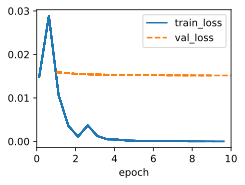

In [51]:
train_scratch(0)

### Using Weight Decay

L2 norm of w: 0.00033268603147007525


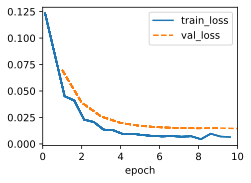

In [43]:
train_scratch(10)

### Concise Implementation

In [28]:
class WeightDecay(d2l.LinearRegression):
    def __init__(self, wd, lr):
        super().__init__(lr)
        self.save_hyperparameters()
        self.wd = wd

    def configure_optimizers(self):
        return torch.optim.SGD([
            {'params': self.net.weight, 'weight_decay': self.wd},
            {'params': self.net.bias}], lr=self.lr)

L2 norm of w: 0.0018109739758074284


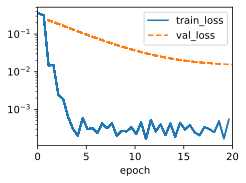

In [30]:
model = WeightDecay(wd=3, lr=0.01)
model.board.yscale='log'
trainer.fit(model, data)

print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))